In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms as tfs

In [2]:
torch.cuda.empty_cache()

In [3]:
transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
class portrait_dataset(Dataset):
    def __init__(self, transform = None):
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir('image_jpg'))
    
    def __getitem__(self, idx):
        im_name = os.listdir('image_jpg')[idx]
        img = Image.open('image_jpg/' + im_name)
        img = img.resize((300, 400))
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
dataset = portrait_dataset(transform)

In [6]:
NOISE_DIM = 75

In [7]:
class generator(nn.Module):
    def __init__(self, noise_dim = NOISE_DIM):
        super(generator, self).__init__()
        self.fc = nn.Sequential(
                    nn.Linear(noise_dim, 1024),
                    nn.ReLU(True),
                    nn.Linear(1024, 7500 * 64),
                    nn.ReLU(True))
        
        self.conv = nn.Sequential(
                    nn.ConvTranspose2d(64, 32, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(32, 3, 4, 2, 1),
                    nn.Tanh())
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 64, 75, 100)
        x = self.conv(x)
        return x

In [8]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(3, 32, 3, stride = 1),
                    nn.ReLU(True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 64, 3, stride = 2),
                    nn.ReLU(True),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(64, 64, 3, stride = 2),
                    nn.ReLU(True),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2, 2)
                    )
        
        self.fc = nn.Sequential(
                nn.Linear(6912, 1000),
                nn.ReLU(True),
                nn.Linear(1000, 100),
                nn.ReLU(True),
                nn.Linear(100, 1))
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [9]:
bce_loss = nn.BCEWithLogitsLoss().cuda()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = torch.ones(size, 1).float().cuda()
    false_labels = torch.zeros(size, 1).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

In [10]:
def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = torch.ones(size, 1).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [11]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0

In [12]:
D_net = nn.DataParallel(discriminator().cuda())
G_net = nn.DataParallel(generator().cuda())
D_net_optim = torch.optim.SGD(D_net.parameters(), lr = 0.01)
G_net_optim = torch.optim.SGD(G_net.parameters(), lr = 0.01)

In [17]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every = 20,
                noise_size=75, num_epochs=3):
    iter_count = 0
    for epoch in range(num_epochs):
        for x in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = x.cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = sample_noise.cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward(retain_graph = True)
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = sample_noise.cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data.item(), g_error.data.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:2])
                plt.show()
                print()
            iter_count += 1

In [18]:
train_data = DataLoader(dataset, batch_size = 4, shuffle = True, drop_last = True)

Iter: 0, D: 1.232, G:0.9616


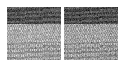


Iter: 20, D: 0.1574, G:2.757


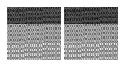


Iter: 40, D: 0.05396, G:3.874


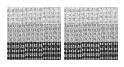


Iter: 60, D: 0.1212, G:4.343


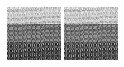


Iter: 80, D: 0.02135, G:4.486


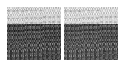

KeyboardInterrupt: 

In [19]:
train_dc_gan(D_net, G_net, D_net_optim, G_net_optim, discriminator_loss, generator_loss, num_epochs=5)